In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools as it
#from evalutils import *
#from lccv import lccv
from tqdm.notebook import tqdm

In [39]:
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

# Reading in Results and Checking Completeness

In [2]:
dfResults = pd.read_csv("results.csv")
dfResults

,openmlid,algorithm,seed,chosenmodel,errorrate,runtime,exception
0,1485,5cv,0,"[('data-pre-processor', RobustScaler(copy=Fals...",0.1375,14827.0,NaN
1,1485,5cv,1,"[('feature-pre-processor', FeatureAgglomeratio...",0.1469,13521.0,NaN
2,1485,10cv,0,"[('data-pre-processor', RobustScaler(copy=Fals...",0.1308,30755.0,NaN
3,1590,5cv,0,"[('predictor', SGDClassifier(alpha=0.000154513...",0.1588,14564.0,NaN
4,1485,10cv,1,"[('predictor', HistGradientBoostingClassifier(...",0.1480,30767.0,NaN
...,...,...,...,...,...,...,...
2675,31,90lccv-flex,7,"[('feature-pre-processor', RBFSampler(gamma=4....",0.2544,2327.0,NaN
2676,40975,90lccv-flex,9,"[('data-pre-processor', Normalizer()), ('predi...",0.0004,5295.0,NaN
2677,31,80lccv-flex,9,"[('data-pre-processor', QuantileTransformer(n_...",0.2597,1443.0,NaN
2678,31,90lccv-flex,8,"[('feature-pre-processor', SelectPercentile(pe...",0.2666,1698.0,NaN


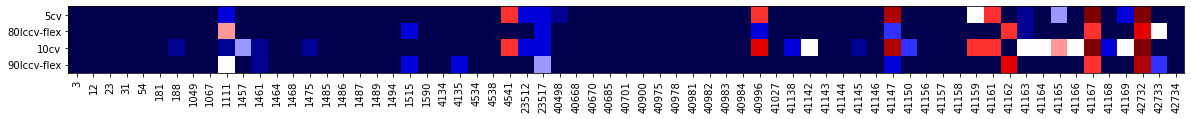

In [3]:
def plot_result_availability(dfResults):
    algorithms = ["5cv", "80lccv-flex", "10cv", "90lccv-flex"]
    datasets = sorted(list(pd.unique(dfResults["openmlid"])))
    Z = np.zeros((len(algorithms), len(datasets)))
    for i, algorithm in enumerate(algorithms):
        for j, openmlid in enumerate(datasets):
            dfProjected = dfResults[(dfResults["algorithm"] == algorithm) & (dfResults["openmlid"] == openmlid)]
            dfProjected = dfProjected[dfProjected["exception"].isna()]
            Z[i,j] = len(dfProjected)
    fig, ax = plt.subplots(1, 1, figsize=(20, 5))
    ax.imshow(-Z, cmap="seismic", vmax=0, vmin=-10)
    ax.set_xticks(range(len(datasets)))
    ax.set_xticklabels(datasets, rotation=90)
    ax.set_yticks(range(len(algorithms)))
    ax.set_yticklabels(algorithms)
    plt.show()
    
plot_result_availability(dfResults)

In [4]:
dfResults80 = dfResults[dfResults["algorithm"].isin(["80lccv-flex", "5cv"]) & (dfResults["exception"].isna())]
dfResults90 = dfResults[dfResults["algorithm"].isin(["90lccv-flex", "10cv"]) & (dfResults["exception"].isna())]

In [5]:
dfResults80.query("algorithm == '5cv' and openmlid == 1111")

,openmlid,algorithm,seed,chosenmodel,errorrate,runtime,exception
465,1111,5cv,0,"[('data-pre-processor', QuantileTransformer(n_...",0.0176,33659.0,NaN
479,1111,5cv,1,"[('data-pre-processor', Normalizer()), ('featu...",0.0177,34125.0,NaN
497,1111,5cv,2,"[('feature-pre-processor', Nystroem(gamma=0.27...",0.0176,33500.0,NaN
516,1111,5cv,3,"[('predictor', RandomForestClassifier(max_feat...",0.0176,32545.0,NaN
1814,1111,5cv,6,"[('feature-pre-processor', SelectPercentile(pe...",0.0250,33286.0,NaN
1839,1111,5cv,7,"[('data-pre-processor', QuantileTransformer(n_...",0.0176,25127.0,NaN
1859,1111,5cv,8,"[('feature-pre-processor', Nystroem(coef0=-0.2...",0.0176,14291.0,NaN
1887,1111,5cv,9,"[('data-pre-processor', QuantileTransformer(n_...",0.0176,24055.0,NaN


# How many cases of performance loss

In [6]:
def create_deviation_list(dfResults):
    
    # absolute runtimes
    algorithms = ["5cv", "80lccv-flex", "10cv", "90lccv-flex"]
    algorithm_names = {"5cv": "5CV", "80lccv-flex": "80LCCV", "10cv": "10CV", "90lccv-flex": "90LCCV"}
    datasets = pd.unique(dfResults["openmlid"])
    
    # pairwise comparisons
    deviations_time = []
    deviations_error = []
    for algo_pair in [("5cv", "80lccv-flex"), ("10cv", "90lccv-flex")]:
        reductions_abs_pair = []
        reductions_rel_pair = []
        performance_diffs_pair = []
        for key, dfForKey in dfResults[dfResults["algorithm"].isin(list(algo_pair))].groupby(["openmlid", "seed"]):
            if len(dfForKey) == 2:
                
                # compute comparison
                row_baseline = dfForKey[dfForKey["algorithm"] == algo_pair[0]]
                row_lccv = dfForKey[dfForKey["algorithm"] == algo_pair[1]]
                runtime_baseline = row_baseline["runtime"].values
                runtime_lccv = row_lccv["runtime"].values
                score_baseline = row_baseline["errorrate"].values
                score_lccv = row_lccv["errorrate"].values
                
                # check undesired cases
                if runtime_baseline < runtime_lccv:
                    deviations_time.append([key[0], key[1], row_baseline["algorithm"].values[0], row_lccv["algorithm"].values[0], row_baseline["runtime"].values[0], row_lccv["runtime"].values[0]])
                if score_baseline < score_lccv:
                    deviations_error.append([key[0], key[1], row_baseline["algorithm"].values[0], row_lccv["algorithm"].values[0], row_baseline["errorrate"].values[0], row_lccv["errorrate"].values[0]])
            
    cols_time = ["openmlid", "seed", "baseline", "lccv", "runtime baseline", "runtime lccv"]
    cols_err = ["openmlid", "seed", "baseline", "lccv", "error rate baseline", "error rate lccv"]
    return (pd.DataFrame(deviations_time, columns=cols_time), pd.DataFrame(deviations_error, columns=cols_err))

            
dfDeviationsTime, dfDeviationsScore = create_deviation_list(dfResults)
dfDeviationsScore = dfDeviationsScore[dfDeviationsScore["error rate baseline"] < dfDeviationsScore["error rate lccv"] - 0.005]

In [7]:
dfDeviationsScore.query("openmlid == 188")

,openmlid,seed,baseline,lccv,error rate baseline,error rate lccv
37,188,0,5cv,80lccv-flex,0.5297,0.5364
38,188,4,5cv,80lccv-flex,0.5148,0.5614
40,188,7,5cv,80lccv-flex,0.5337,0.5395
42,188,9,5cv,80lccv-flex,0.5144,0.5386
365,188,2,10cv,90lccv-flex,0.5139,0.5288
366,188,4,10cv,90lccv-flex,0.5155,0.5268
367,188,5,10cv,90lccv-flex,0.5150,0.5595
368,188,7,10cv,90lccv-flex,0.5278,0.5592
369,188,8,10cv,90lccv-flex,0.5128,0.5400
370,188,9,10cv,90lccv-flex,0.5139,0.5368


In [8]:
for (openmlid, baseline), dfDeviationsScoreOnDataset in dfDeviationsScore.groupby(["openmlid", "baseline"]):
    if np.mean(dfDeviationsScoreOnDataset["error rate lccv"] - dfDeviationsScoreOnDataset["error rate baseline"]) > 0.02:
        print(f"{openmlid} ({baseline}): {len(dfDeviationsScoreOnDataset)}")

23 (10cv): 4
54 (5cv): 5
181 (10cv): 5
188 (10cv): 6
188 (5cv): 4
1111 (5cv): 1
1457 (10cv): 1
1457 (5cv): 4
1464 (10cv): 7
40498 (10cv): 4
40668 (5cv): 6
40685 (10cv): 1
41027 (5cv): 3
41147 (5cv): 1
41157 (10cv): 4
41157 (5cv): 7
41159 (5cv): 2
41164 (10cv): 4
41164 (5cv): 7
41166 (5cv): 6
41168 (5cv): 3


# Find out "Expensive" Datasets

In [9]:
expensive_datasets = []
for openmlid, dfDataset in dfResults80.groupby("openmlid"):
    if np.mean(dfDataset[dfDataset["algorithm"] == "80lccv-flex"]["runtime"]) > 3600 * 6:
        expensive_datasets.append(openmlid)
print(f"There are {len(expensive_datasets)} expensive datastes: {expensive_datasets}")

There are 19 expensive datastes: [1457, 4135, 4541, 23512, 23517, 40996, 41147, 41150, 41159, 41161, 41163, 41164, 41165, 41166, 41167, 41168, 41169, 42732, 42733]


# Comparison Plots

In [10]:
datasets_dense = [1485, 1515, 1475, 1468, 1489, 23512, 23517, 40981, 40982, 40983, 40984, 40701, 40685, 40900,  1111, 40498, 41161, 41162, 41163, 41164, 41165, 41166, 41167, 41168, 41169, 41142, 41143, 41144, 41145, 41146, 41150, 41156, 41157, 41158,  41159, 41138, 54, 181, 188, 1461, 1494, 1464, 12, 23, 3, 1487, 40668, 1067, 1049, 40975, 31]
#1457
datasets_sparse = [1590, 1486, 4534, 4541, 4538, 4134, 4135, 40978, 40996, 41027, 40670, 42732, 42733, 42734, 41147]
datasets = datasets_dense + datasets_sparse

In [41]:
def create_summary_scatterplot(dfResults, suffix):
    fig, ax = plt.subplots(figsize=(15, 15))
    i = 0
    for openmlid, dfDataset in dfResults.groupby("openmlid"):
        dfLCCV = dfDataset[dfDataset["algorithm"].isin(["80lccv-flex", "90lccv-flex"])]
        dfBaseline = dfDataset[dfDataset["algorithm"].isin(["5cv", "10cv"])]
        lccv = [dfLCCV["errorrate"], np.mean(dfLCCV["runtime"])]
        mccv = [dfBaseline["errorrate"], np.mean(dfBaseline["runtime"])]
        mccv_has_result = not all(np.isnan(mccv[0]))
        
        lccv_name = list(pd.unique(dfLCCV["algorithm"]))[0][:-5].upper()
        base_name = "5CV" if lccv_name == "80LCCV" else "10CV"
        
        lccv_mean_error = np.median(lccv[0])
        mccv_mean_error = np.median(mccv[0])
        
        ax.scatter(lccv[1], lccv_mean_error, color="C0", label=lccv_name if i == 0 else None)
        ax.plot([lccv[1], lccv[1]], [np.percentile(lccv[0], 20), np.percentile(lccv[0], 80)], color="C0", linewidth=1, alpha=0.5)
        if mccv_has_result:
            ax.scatter(mccv[1], mccv_mean_error, color="C1", label=base_name if i == 0 else None)
            ax.plot([mccv[1], mccv[1]], [np.percentile(mccv[0], 20), np.percentile(mccv[0], 80)], color="C1", linewidth=1, alpha=0.5) # vertical line for range
            ax.plot([lccv[1], mccv[1]], [lccv_mean_error, mccv_mean_error], color="green" if lccv[1] < mccv[1] else "red", linestyle="--", linewidth=1) # connecting line
            ax.text((lccv[1] + mccv[1]) / 2.1, (lccv_mean_error + mccv_mean_error) / 2, int(openmlid))
            avg_time_saving = int((mccv[1] - lccv[1]) / 60)
            avg_reduction = np.round((1 - lccv[1] / mccv[1]) * 100)
            ax.text((lccv[1] + mccv[1]) / 2.5, (lccv_mean_error + mccv_mean_error) / 2 - 0.01, str(avg_time_saving) + "m (" + str(avg_reduction) + "%)")
        else:
            ax.text(lccv[1], lccv_mean_error, int(openmlid))
        i += 1
    ax.set_xlabel("Runtime (s)")
    ax.set_ylabel("Error Rate")
    for y in np.linspace(0, 0.7, 71):
        ax.axhline(y, alpha=0.05, color="black")
    ax.axvline(1800, linestyle="--", color="black", linewidth=1)
    ax.axvline(3600, linestyle="--", color="black", linewidth=1)
    ax.axvline(36000, linestyle="--", color="black", linewidth=1)
    ax.set_ylim([0, 0.7])
    ax.set_xlim([5 * 10**2, 10**5])
    ax.set_xscale("log")
    ax.legend()
    fig.tight_layout()
    fig.savefig(f"plots/results-randomsearch-scatter-{suffix}.pdf")
    plt.show()
    

def create_summary_boxplots(dfResults, ax = None):
    
    if ax is None:
        fig, ax = plt.subplots(1, 4, figsize=(8, 3), gridspec_kw={'width_ratios': [1.2, 1, 1, 1]})
    else:
        fig = None
    
    # absolute runtimes
    algorithms = ["5cv", "80lccv-flex", "10cv", "90lccv-flex"]
    algorithm_names = {"5cv": "5CV", "80lccv-flex": "80LCCV", "10cv": "10CV", "90lccv-flex": "90LCCV"}
    datasets = pd.unique(dfResults["openmlid"])
    ax[0].boxplot([dfResults[dfResults["algorithm"] == a]["runtime"].values / 60 for a in algorithms])
    ax[0].set_title("Absolute\nRuntimes (m)")
    ax[0].set_ylim([0, 60 * 24])
    ax[0].set_xticks(range(1, 5))
    ax[0].set_xticklabels([algorithm_names[a] for a in algorithms], rotation=45)
    
    # pairwise comparisons
    reductions_abs = []
    reductions_rel = []
    performance_diffs = []
    for algo_pair in [("5cv", "80lccv-flex"), ("10cv", "90lccv-flex")]:
        reductions_abs_pair = []
        reductions_rel_pair = []
        performance_diffs_pair = []
        for openmlid, dfDataset in dfResults[dfResults["algorithm"].isin(list(algo_pair))].groupby("openmlid"):
            runtime_baseline = np.mean(dfDataset[dfDataset["algorithm"] == algo_pair[0]]["runtime"])
            runtime_lccv = np.mean(dfDataset[dfDataset["algorithm"] == algo_pair[1]]["runtime"])
            score_baseline = np.median(dfDataset[dfDataset["algorithm"] == algo_pair[0]]["errorrate"])
            score_lccv = np.mean(dfDataset[dfDataset["algorithm"] == algo_pair[1]]["errorrate"])
            if not np.isnan(runtime_baseline):
                reductions_abs_pair.append(runtime_baseline - runtime_lccv)
                reductions_rel_pair.append(runtime_lccv / runtime_baseline)
                performance_diffs_pair.append(score_lccv - score_baseline)
        reductions_abs.append(reductions_abs_pair)
        reductions_rel.append(reductions_rel_pair)
        performance_diffs.append(performance_diffs_pair)
    for i, (name, reductions) in enumerate([("Absolute\nReduction (m)", reductions_abs), ("Reduction\nRatio (\%)", reductions_rel)], 1):
        reductions = np.array(reductions).T
        if i == 1:
            reductions /= 60
            print(f"Median of absolute reduction is {np.median(reductions[:,0])} for 80LCCV and {np.median(reductions[:,1])} for 90LCCV")
            print(f"Mean of absolute reduction is {np.mean(reductions[:,0])} for 80LCCV and {np.mean(reductions[:,1])} for 90LCCV")
        else:
            print(f"Median of relative reduction is {np.median(reductions[:,0])} for 80LCCV and {np.median(reductions[:,1])} for 90LCCV")
            print(f"Mean of relative reduction is {np.mean(reductions[:,0])} for 80LCCV and {np.mean(reductions[:,1])} for 90LCCV")
        ax[i].violinplot(reductions, showmedians=True)
        ax[i].set_title(name)
        ax[i].axhline(np.mean(reductions[:,0]), linestyle="--", linewidth=1, color="black", xmin=0.1, xmax=.3)
        ax[i].axhline(np.mean(reductions[:,1]), linestyle="--", linewidth=1, color="black", xmin=.7, xmax=.9)
    
    # info on percentage of observations with runtime reductions of at least 50%
    print(np.count_nonzero(np.array(reductions_rel) <= 0.5, axis=1) / len(reductions_rel[1]))
    print(np.mean(np.array(reductions_abs), axis=1)/3600)
    
    # deviations in performance
    ax[3].boxplot(performance_diffs)
    ax[3].set_title("Absolute\nPerformance Diff.")
    for threshold in [0.005, 0.01, 0.015]:
        for i, diffs in enumerate(performance_diffs):        
            print(f"{np.round(100 * np.count_nonzero(np.array(diffs) <= threshold) / len(diffs), 2)}% of the observed error rates of lccv deviate by at most {threshold} from the {'5CV' if i == 0 else '10CV'} baseline.")
    
    # set x labels for comparative plots
    for i in range(1, 4):
        ax[i].set_xticks(range(1, 3))
        ax[i].set_xticklabels(["80\%", "90\%"])
        ax[i].set_xlabel("Max Tr. Port.")
    
    
    if fig is not None:
        fig.tight_layout()
        fig.savefig("plots/results-randomsearch-boxplots.pdf")
        plt.show()
    
    for algorithm in pd.unique(dfResults["algorithm"]):
        print(f"Avg. Total Runtime of {algorithm}: {np.nanmean([np.nanmean(group['runtime']) for openmlid, group in dfResults[dfResults['algorithm'] == algorithm].groupby('openmlid')])}")

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Median of absolute reduction is 53.216296296296285 for 80LCCV and 165.34833333333336 for 90LCCV
Mean of absolute reduction is 91.41528612128612 for 80LCCV and 165.35928907203908 for 90LCCV
Median of relative reduction is 0.7125547108961069 for 80LCCV and 0.6300976811644853 for 90LCCV
Mean of relative reduction is 0.8283242882733642 for 80LCCV and 0.6552558567377196 for 90LCCV
[0.01538462 0.21538462]
[1.5235881  2.75598815]
76.92% of the observed error rates of lccv deviate by at most 0.005 from the 5CV baseline.
67.69% of the observed error rates of lccv deviate by at most 0.005 from the 10CV baseline.
83.08% of the observed error rates of lccv deviate by at most 0.01 from the 5CV baseline.
83.08% of the observed error rates of lccv deviate by at most 0.01 from the 10CV baseline.
90.77% of the observed error rates of lccv deviate by at most 0.015 from the 5CV baseline.
89.23% of the observed error rates of lccv deviate by at most 0.015 from the 10CV baseline.
Avg. Total Runtime of 5cv:

/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/felix/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Median of absolute reduction is 235.11666666666667 for 80LCCV and 279.42083333333335 for 90LCCV
Mean of absolute reduction is 186.24464519140992 for 80LCCV and 235.77179971988798 for 90LCCV
Median of relative reduction is 0.6960519978391185 for 80LCCV and 0.6683117206559084 for 90LCCV
Mean of relative reduction is 0.762381833741426 for 80LCCV and 0.7037857842344177 for 90LCCV
[0. 0.]
[3.10407742 3.92953   ]
52.94% of the observed error rates of lccv deviate by at most 0.005 from the 5CV baseline.
52.94% of the observed error rates of lccv deviate by at most 0.005 from the 10CV baseline.
64.71% of the observed error rates of lccv deviate by at most 0.01 from the 5CV baseline.
64.71% of the observed error rates of lccv deviate by at most 0.01 from the 10CV baseline.
76.47% of the observed error rates of lccv deviate by at most 0.015 from the 5CV baseline.
76.47% of the observed error rates of lccv deviate by at most 0.015 from the 10CV baseline.
Avg. Total Runtime of 5cv: 40734.175816993

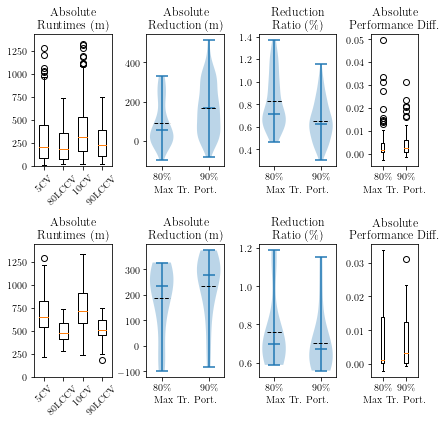

In [42]:
fig, ax = plt.subplots(2, 4, figsize=(6, 6), gridspec_kw={'width_ratios': [1, 1, 1, .6]})

create_summary_boxplots(dfResults[dfResults["exception"].isna()], ax[0])
create_summary_boxplots(dfResults[(dfResults["exception"].isna()) & (dfResults["openmlid"].isin(expensive_datasets))], ax[1])

fig.tight_layout()
fig.subplots_adjust(wspace = .5)
fig.savefig("plots/results-randomsearch-boxplots.pdf")
plt.show()

In [ ]:
create_summary_scatterplot(dfResults80, "80")

In [ ]:
create_summary_scatterplot(dfResults90, "90")

In [ ]:
def get_latex_table(dfResults):
    rows = []
    for openmlid in tqdm(sorted(pd.unique(dfResults["openmlid"]))):
        df_ds = dfResults[dfResults["openmlid"] == openmlid]
        mask_lccv = df_ds["algorithm"].isin(["80lccv-flex", "90lccv-flex"])
        df_lccv = df_ds[mask_lccv]
        df_10cv = df_ds[~mask_lccv]
        
        performance_lccv = str(np.round(np.mean(df_lccv["errorrate"]), 2)) + "$\pm$" + '{:04.2f}'.format(np.std(df_lccv["errorrate"]), 2)
        runtime_lccv = str(int(np.round(np.mean(df_lccv["runtime"])))) + "$\pm$" + str(int(np.round(np.std(df_lccv["runtime"]))))
        
        # get results for baseline
        if len(df_10cv) > 0:
            performance_10cv = str(np.round(np.mean(df_10cv["errorrate"]), 2)) + "$\pm$" + '{:04.2f}'.format(np.std(df_10cv["errorrate"]), 2)
            runtime_10cv = str(int(np.round(np.mean(df_10cv["runtime"])))) + "$\pm$" + str(int(np.round(np.std(df_10cv["runtime"]))))
        else:
            performance_10cv, runtime_10cv = np.nan, 86400
        
        rows.append([openmlid, performance_lccv, runtime_lccv, performance_10cv, runtime_10cv])
    columns = ["openmlid", "LCCV Performance", "LCCV Runtime", "Baseline CV Perf", "Baseline CV Runtime"]
    return pd.DataFrame(rows, columns=columns).to_latex(index=False, escape=False)

In [ ]:
print(get_latex_table(dfResults80))

In [ ]:
print(get_latex_table(dfResults90))